In [224]:
import os
def get_file_paths(directory):
    """
    Get file paths from the specified directory.
    
    Args:
    - directory: The directory to traverse.
    
    Returns:
    - file_paths: List of file paths found in the directory.
    """
    file_paths = []
    # Walk through the directory and its subdirectories
    for root, directories, files in os.walk(directory):
        for file in files:
            # Get the absolute path of the file
            file_path = os.path.join(root, file)
            # Append the file path to the list
            file_paths.append(file_path)
    return file_paths

In [282]:
import numpy as np
import cv2  # You may need to install OpenCV: pip install opencv-python

# Assuming you have a list of file paths to your spectrogram images
file_paths = get_file_paths('/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n')
#file_paths = '../working/bioacousticsoutput/'  # List of file paths to your spectrogram images
#print (file_paths)
# Initialize an empty list to store spectrogram data
spectrogram_data = []

# Load and preprocess each spectrogram image
for file_path in file_paths:
    print(file_path)
    # Load the spectrogram image (assuming it's grayscale)
    spectrogram_img = cv2.imread(file_path)[...,::-1]
    
    # Resize the spectrogram image if necessary
    # spectrogram_img = cv2.resize(spectrogram_img, (938, 513))  # Resize to match model input size if necessary
    
    # Normalize the spectrogram image
    spectrogram_img = spectrogram_img.astype('float32') / 255.0
    
    #spectrogram_img = spectrogram_img.reshape((350, 640, 1))
    
    # Add the spectrogram data to the list
    spectrogram_data.append(spectrogram_img)

# Convert the list of spectrogram data into a numpy array
X_train = np.array(spectrogram_data)

# Reshape the data if necessary (depends on your model input shape)
#X_train = X_train.reshape(938, 513, X_train.shape[0])  # If the model expects a 4D tensor

# Print the shape of the training data
print("Shape of X_train:", X_train.shape)

/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20240131_180000_6.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20240129_160000_5.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230117_212400_11.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230117_183800_11.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20240131_141800_25.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230410_105000_6.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230117_210000_17.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230227_090200_9.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230117_210400_1.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230410_105600_17.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230410_105200_4.png
/home/daniel/Projects/SRMP/Audio/Data/spectrograms/train/n/20230117_210000_12.png
/home/daniel/Projects/

In [283]:
np.random.shuffle(X_train)

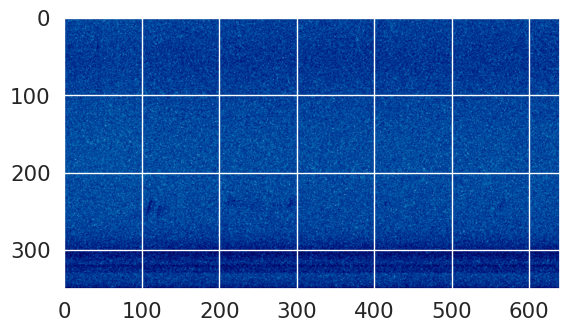

In [284]:
plt.imshow(X_train[0])

In [285]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, ZeroPadding2D, Cropping2D
from tensorflow.keras.models import Model

# Define input dimensions
img_height, img_width = 350, 640

# Define the autoencoder model
def build_autoencoder():
  input_img = Input(shape=(img_height, img_width, 3))
  print(input_img.shape)

  # Encoder  
  x = ZeroPadding2D(padding=(1, 0))(input_img)  # Add padding before pooling
  x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
  x = MaxPooling2D((2, 2), padding="same")(x)  # Adjust pooling for consistency
  x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
  x = MaxPooling2D((2, 2), padding="same")(x)  # Adjust pooling for consistency
  encoded = Conv2D(16, (3, 3), activation="relu", padding="same")(x)

  # Decoder
  x = Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(encoded)
  x = UpSampling2D((2, 2))(x)  # Maintain consistent dimensions
  x = Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)
  x = UpSampling2D((2, 2))(x)  # Maintain consistent dimensions
  x = Cropping2D(cropping=((2, 0), (0, 0)))(x)  # Crop 1 row from top
  decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x) 

  # Build the model
  autoencoder = Model(inputs=input_img, outputs=decoded)
  autoencoder.compile(optimizer="adam", loss="mse")

  return autoencoder

# Create and train the model
model = build_autoencoder()
model.summary()


(None, 350, 640, 3)


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 350, 640, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_6                │ (None, 352, 640, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 352, 640, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 176, 320, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 176, 320, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 88, 160, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 88, 160, 16)    │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 88, 160, 64)    │         9,280 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 176, 320, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 176, 320, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 352, 640, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cropping2d_6 (Cropping2D)       │ (None, 350, 640, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 350, 640, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,235 (223.57 KB)

 Trainable params: 57,235 (223.57 KB)

 Non-trainable params: 0 (0.00 B)

In [286]:
model.fit(X_train, X_train, epochs=50, batch_size=32)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 663ms/step - loss: 0.0662
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 619ms/step - loss: 0.0135
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 617ms/step - loss: 0.0093
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 619ms/step - loss: 0.0064
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 616ms/step - loss: 0.0036
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 620ms/step - loss: 0.0030
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 618ms/step - loss: 0.0028
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step - loss: 0.0026
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 637ms/step - loss: 0.0025
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 646ms/step - loss: 0.0026
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 644ms/step - loss: 0.0025
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 631ms/step - loss: 0.0025
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 620ms/step - loss: 0.0025
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 621ms/step - loss: 0.0024
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 6

In [287]:
import tensorflow as tf
test_dir = '/home/daniel/Projects/SRMP/Audio/Data/spectrograms/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            color_mode = 'rgb',
                                                            batch_size = 32,
                                                            image_size=(350, 640),
                                                            shuffle=True,
                                                            label_mode='binary',
                                                            class_names=['n','y'],
                                                            seed=0)

Found 102 files belonging to 2 classes.


In [288]:
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal")
        #tf.keras.layers.RandomRotation(0.1)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

In [289]:
test_dataset = prepare(test_dataset)

In [75]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
#    x
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   image_pred = model.predict(image_batch)
   # append predicted labels
   mse=tf.keras.losses.MSE(image_batch, image_pred)
   y_pred.append(mse)


# convert the true and predicted labels into tensors
#correct_labels = tf.concat([item for item in y_true], axis = 0)
#predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


2024-05-30 09:51:43.914699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [211]:
test_list = model.predict(test_dataset)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [245]:
test_dataset.shape

AttributeError: '_MapDataset' object has no attribute 'shape'

In [305]:
mse_pred = []
y_true = []
num = 0
for dataset in test_dataset.unbatch():
    x, y = dataset
    image_pred = model.predict(x.numpy().reshape(1, 350, 640, 3))
    y_true.append(y.numpy().tolist())
    mse = (np.square(x - image_pred)).mean(axis=None)
    mse_pred.append(mse)
    #image_pred = model.predict(x_batch[0])
    #print(len(x_batch))
    #mse = (np.square(x_batch - image_pred)).mean(axis=None)
    #mse_pred.append(mse)
    #mse = (np.square(x - image_pred)).mean(axis=None)
    #y_pred.append(image_pred)
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

2024-05-30 13:26:20.754795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [265]:
mse_pred

[0.0018679618,
 0.002548758,
 0.0017986181,
 0.0016382202,
 0.00324749,
 0.0013476323,
 0.0015468018,
 0.0024939252,
 0.0023625006,
 0.0021286171,
 0.0009680211,
 0.002800403,
 0.0019784733,
 0.002117567,
 0.0017910613,
 0.0024891293,
 0.0014072267,
 0.001987823,
 0.0014606728,
 0.0023158814,
 0.0024150433,
 0.001606375,
 0.0016358438,
 0.0013300814,
 0.00097082066,
 0.0017922426,
 0.0015775611,
 0.0021120561,
 0.0017292154,
 0.0013966694,
 0.0020338285,
 0.0011946151,
 0.0014307551,
 0.0015467405,
 0.001243751,
 0.0014477093,
 0.0021938747,
 0.0017724656,
 0.002890014,
 0.0022204546,
 0.002586171,
 0.0027765653,
 0.0026044745,
 0.0017690397,
 0.0011847505,
 0.0016699233,
 0.0013192223,
 0.001109559,
 0.0016572238,
 0.001061327,
 0.0025364093,
 0.002015586,
 0.0019307416,
 0.0026074285,
 0.0017408063,
 0.0017810799,
 0.0019369585,
 0.0024986838,
 0.0021555382,
 0.0017903039,
 0.0023676825,
 0.0014863743,
 0.0016007721,
 0.0025186874,
 0.0015114105,
 0.001903541,
 0.002080385,
 0.002123

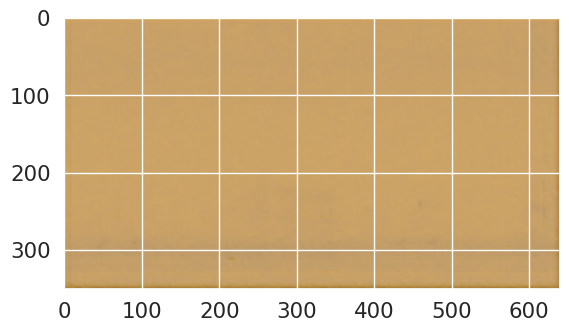

In [241]:
plt.imshow(test_list[100])

In [291]:
y_true

[[1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [0.0],
 [0.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [1.0],
 [0.0],
 [1.0],
 [1.0],
 [0.0],
 [0.0],
 [1.0],
 [0.0]]

In [294]:
mse_pred

[0.0013295682,
 0.0026770378,
 0.0020011724,
 0.0022529701,
 0.0017530425,
 0.0009620394,
 0.0019929493,
 0.001410604,
 0.0017563086,
 0.0025206509,
 0.0010367483,
 0.0020209842,
 0.0023957286,
 0.0016773313,
 0.0020228894,
 0.00124982,
 0.0025744233,
 0.0016767799,
 0.0032180971,
 0.0023967328,
 0.0017990808,
 0.0011892326,
 0.0017096761,
 0.0016549728,
 0.002124166,
 0.0020635629,
 0.0013603613,
 0.00081758265,
 0.0012809628,
 0.001560854,
 0.0013123325,
 0.0020259686,
 0.0020885614,
 0.0017526317,
 0.0029192863,
 0.0020112689,
 0.0018079669,
 0.0018158422,
 0.0025114354,
 0.0024465716,
 0.0012205105,
 0.0015838618,
 0.0024773912,
 0.0025411597,
 0.0024629284,
 0.002345626,
 0.0019447507,
 0.0021426033,
 0.002794186,
 0.0016687575,
 0.002862253,
 0.0017431128,
 0.0015519538,
 0.0021812054,
 0.0021957774,
 0.0018767678,
 0.0011146698,
 0.002113151,
 0.0019619241,
 0.0020157269,
 0.0015194695,
 0.0017815112,
 0.0022065823,
 0.0023520824,
 0.0021097015,
 0.0018190079,
 0.0017366633,
 0.

In [307]:
y_true = [1,0,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,1,1,0,1,1,0,0,0,1,0,0,1,1,1,0,0,0,1,0,1,0,1,1,1,0,0,0,0,1,0,0,1,1,0,1,1,1,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,1,1,1,1,0,0,0,0,1,1,1,1,1,0,1,1,0,0,1,0]

In [308]:
import pandas as pd

error_df = pd.DataFrame({'Reconstruction_error': mse_pred,
                        'True_class': y_true})
error_df.describe()

,Reconstruction_error,True_class
count,102.000000,102.000000
mean,0.001886,0.500000
std,0.000504,0.502469
min,0.000818,0.000000
25%,0.001519,0.000000
50%,0.001815,0.500000
75%,0.002204,1.000000
max,0.003218,1.000000


In [274]:
import matplotlib.pyplot as plt

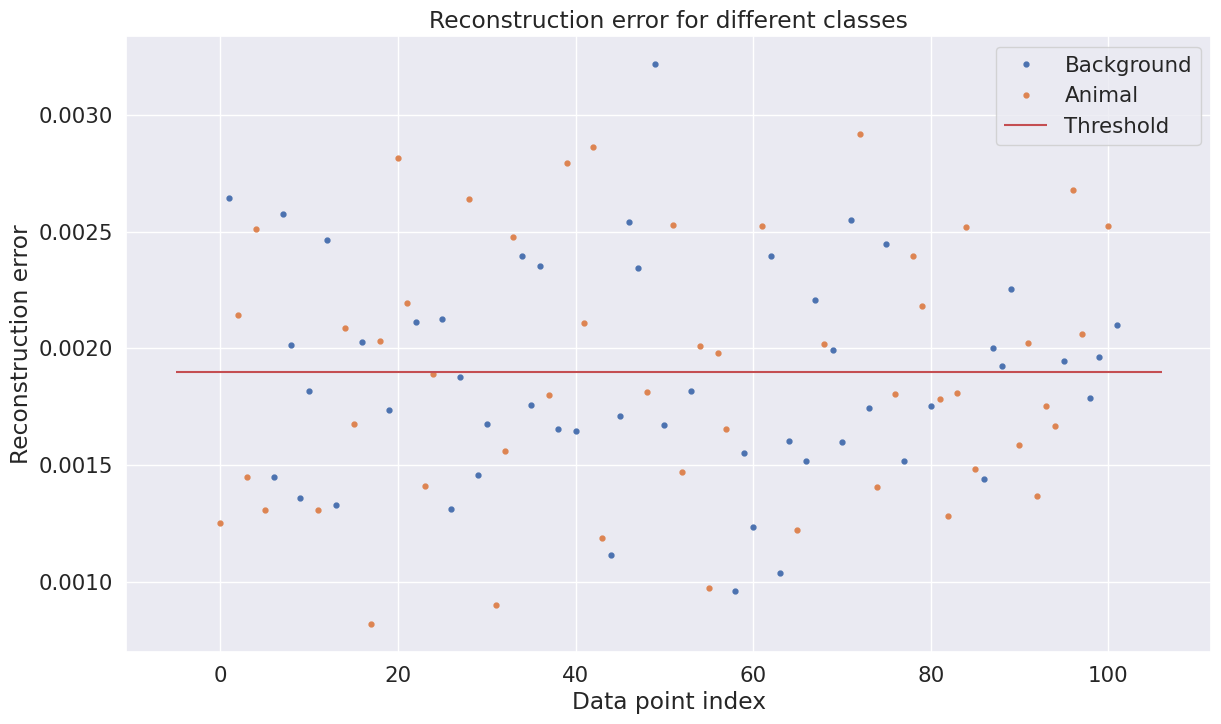

In [309]:
threshold_fixed = 0.0019
groups = error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(14, 8))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Animal" if name == 1 else "Background")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1],
          colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [278]:
error_df

,Reconstruction_error,True_class
0,0.001868,1
1,0.002549,0
2,0.001799,0
3,0.001638,1
4,0.003247,1
...,...,...
97,0.000807,0
98,0.001351,0
99,0.001477,0
100,0.002497,0


In [270]:
y_true.size

AttributeError: 'list' object has no attribute 'size'

In [179]:

conf_matrix = confusion_matrix(error_df.True_class, pred_y)

NameError: name 'confusion_matrix' is not defined

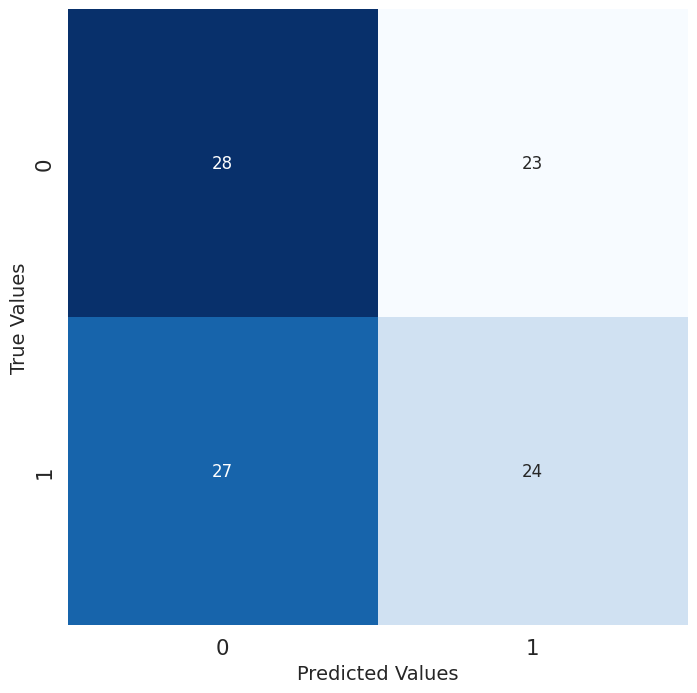

In [310]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

cm = confusion_matrix(error_df.True_class, pred_y)
fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(1,1,1)
sns.set(font_scale=1.4) #for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 12},
     cbar = False, cmap='Blues');
ax1.set_ylabel('True Values',fontsize=14)
ax1.set_xlabel('Predicted Values',fontsize=14)
plt.show()

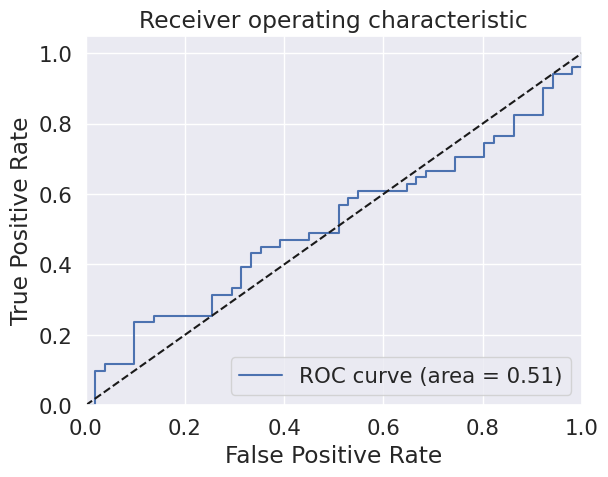

In [311]:
from sklearn.metrics import roc_curve, auc
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class,
                                                      error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [252]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img_path = '/home/daniel/Projects/SRMP/Audio/Data/spectrograms/test/n/20230117_183800_15.png'
img = load_img(img_path)
img_array = img_to_array(img) / 255.0
img_array = img_array.reshape(1, 350, 640, 3)

In [253]:
reconstructed = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


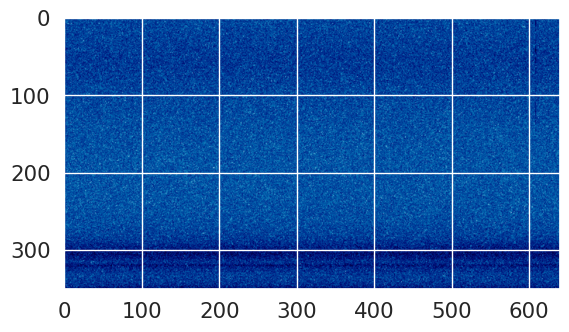

In [260]:
plt.imshow(reconstructed[0])
plt.imshow(img_array[0])
plt.show()

In [256]:
mse = (np.square(img_array - reconstructed)).mean(axis=None)

In [257]:
mse

0.0026074285

In [312]:
from sklearn.metrics import classification_report

print(classification_report(error_df.True_class, pred_y))

              precision    recall  f1-score   support

           0       0.51      0.55      0.53        51
           1       0.51      0.47      0.49        51

    accuracy                           0.51       102
   macro avg       0.51      0.51      0.51       102
weighted avg       0.51      0.51      0.51       102

